(newton_method)=
```{raw} html
<div id="qe-notebook-header" align="right" style="text-align:right;">
        <a href="https://quantecon.org/" title="quantecon.org">
                <img style="width:250px;display:inline;" width="250px" src="https://assets.quantecon.org/img/qe-menubar-logo.svg" alt="QuantEcon">
        </a>
</div>
```
```{index} single: python
```

# Using Newton's Method to Solve Economic Models

```{contents} Contents
:depth: 2
```

## Overview

Many economic problems involve finding [fixed
points](https://en.wikipedia.org/wiki/Fixed_point_(mathematics)) or
[zeros](https://en.wikipedia.org/wiki/Zero_of_a_function) (sometimes called
"roots") of functions.

For example, in a simple supply and demand model, an equilibrium price is one
that makes excess demand zero.  

In other words, an equilibrium is a zero of the excess demand function.

There are various computational techniques for solving for fixed points and
zeros.

In this lecture we study an important gradient-based technique called [Newton's
method](https://en.wikipedia.org/wiki/Newton%27s_method).

Newton's method does not always work but, in situations where it does,
convergence is often fast when compared to other methods.

The lecture will apply Newton's method in one-dimensional and
multi-dimensional settings to solve fixed-point and zero-finding problems. 

* When finding the fixed point of a function $f$, Newton's method updates
  an existing guess of the fixed point by solving for the fixed point of a
  linear approximation to the function $f$.

* When finding the zero of a function $f$, Newton's method updates
  an existing guess by solving for the zero of a linear approximation to
  the function $f$.

To build intuition, we first consider an easy, one-dimensional fixed point
problem where we know the solution and solve it using both successive
approximation and Newton's method.

Then we apply Newton's method to multi-dimensional settings to solve
market for equilibria with multiple goods.

At the end of the lecture we leverage the power of JAX and automatic
differentiation to solve a very high-dimensional equilibrium problem.

We use the following imports in this lecture

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from collections import namedtuple
from scipy.optimize import root
import jax
import jax.numpy as jnp

plt.rcParams["figure.figsize"] = (10, 5.7)

## Fixed Point Computation Using Newton's Method

In this section we solve the fixed point of the law of motion for capital in
the setting of the [Solow growth
model](https://en.wikipedia.org/wiki/Solow%E2%80%93Swan_model).

We will inspect the fixed point visually, solve it by successive
approximation, and then apply Newton's method to achieve faster convergence.

(solow)=
### The Solow Model

In the Solow growth model, assuming Cobb-Douglas production technology and
zero population growth, the law of motion for capital is

```{math}
:label: motion_law
    k_{t+1} = g(k_t) \quad \text{where} \quad
    g(k) := sAk^\alpha + (1-\delta) k
```

Here

- $k_t$ is capital stock per worker,
- $A, \alpha>0$ are production parameters, $\alpha<1$
- $s>0$ is a savings rate, and
- $\delta \in(0,1)$ is a rate of depreciation

In this example, we wish to calculate the unique strictly positive fixed point
of $g$, the law of motion for capital.

In other words, we seek a $k^* > 0$ such that $g(k^*)=k^*$.

* such a $k^*$ is called a [steady state](https://en.wikipedia.org/wiki/Steady_state),
  since $k_t = k^*$ implies $k_{t+1} = k^*$.

Using pencil and paper to solve $g(k)=k$, you will be able to confirm that

$$ k^* = \left(\frac{s A}{δ}\right)^{1/(1 - α)}  $$

### Implementation

Let's store our parameters in [`namedtuple`](https://docs.python.org/3/library/collections.html#collections.namedtuple) to help us keep our code clean and concise.

In [2]:
SolowParameters = namedtuple("SolowParameters", ('A', 's', 'α', 'δ'))

This function creates a suitable `namedtuple` with default parameter values.

In [3]:
def create_solow_params(A=2.0, s=0.3, α=0.3, δ=0.4):
    "Creates a Solow model parameterization with default values."
    return SolowParameters(A=A, s=s, α=α, δ=δ)

The next two functions implement the law of motion [](motion_law) and store the true fixed point $k^*$.

In [4]:
def g(k, params):
    A, s, α, δ = params
    return A * s * k**α + (1 - δ) * k
    
def exact_fixed_point(params):
    A, s, α, δ = params
    return ((s * A) / δ)**(1/(1 - α))

Here is a function to provide a 45 degree plot of the dynamics.

In [5]:
def plot_45(params, ax, fontsize=14):
    
    k_min, k_max = 0.0, 3.0
    k_grid = np.linspace(k_min, k_max, 1200)

    # Plot the functions
    lb = r"$g(k) = sAk^{\alpha} + (1 - \delta)k$"
    ax.plot(k_grid, g(k_grid, params),  lw=2, alpha=0.6, label=lb)
    ax.plot(k_grid, k_grid, "k--", lw=1, alpha=0.7, label="45")

    # Show and annotate the fixed point
    kstar = exact_fixed_point(params)
    fps = (kstar,)
    ax.plot(fps, fps, "go", ms=10, alpha=0.6)
    ax.annotate(r"$k^* = (sA / \delta)^{\frac{1}{1-\alpha}}$", 
             xy=(kstar, kstar),
             xycoords="data",
             xytext=(20, -20),
             textcoords="offset points",
             fontsize=fontsize)

    ax.legend(loc="upper left", frameon=False, fontsize=fontsize)

    ax.set_yticks((0, 1, 2, 3))
    ax.set_yticklabels((0.0, 1.0, 2.0, 3.0), fontsize=fontsize)
    ax.set_ylim(0, 3)
    ax.set_xlabel("$k_t$", fontsize=fontsize)
    ax.set_ylabel("$k_{t+1}$", fontsize=fontsize)

Let's look at the 45 degree diagram for two parameterizations.

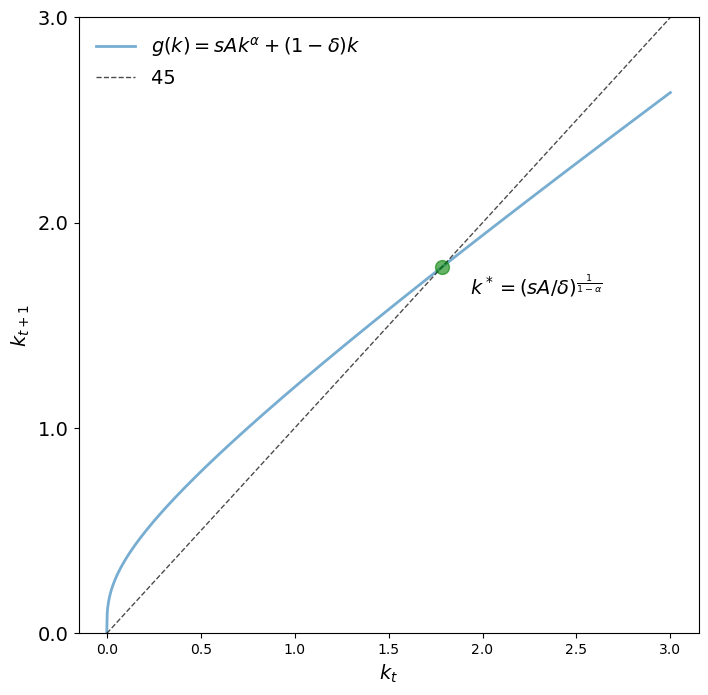

In [6]:
params = create_solow_params()
fig, ax = plt.subplots(figsize=(8, 8))
plot_45(params, ax)
plt.show()

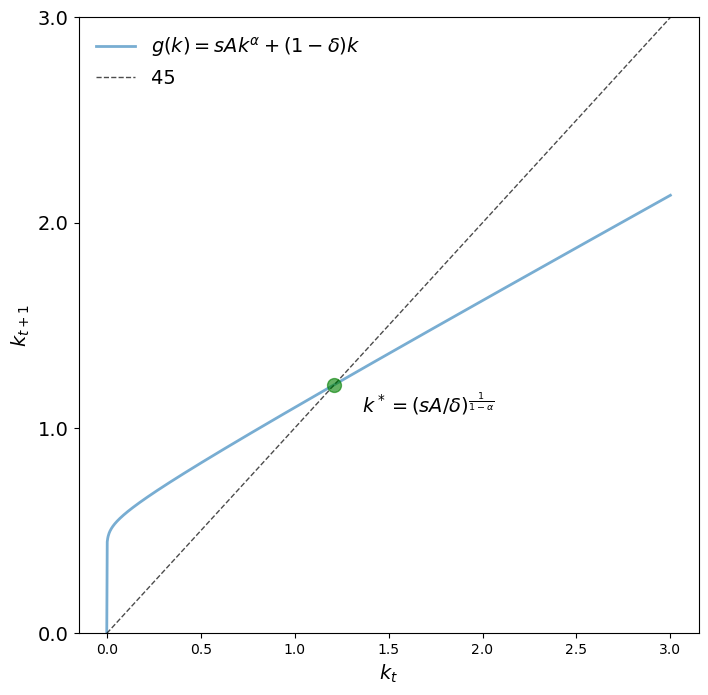

In [7]:
params = create_solow_params(α=0.05, δ=0.5)
fig, ax = plt.subplots(figsize=(8, 8))
plot_45(params, ax)
plt.show()

We see that $k^*$ is indeed the unique positive fixed point.


#### Successive Approximation

First let's compute the fixed point using successive approximation.

In this case, successive approximation means repeatedly updating capital
from some initial state $k_0$ using the law of motion.

Here's a time series from a particular choice of $k_0$.

In [8]:
def compute_iterates(k_0, f, params, n=25):
    "Compute time series of length n generated by arbitrary function f."
    k = k_0
    k_iterates = []
    for t in range(n):
        k_iterates.append(k)
        k = f(k, params)
    return k_iterates

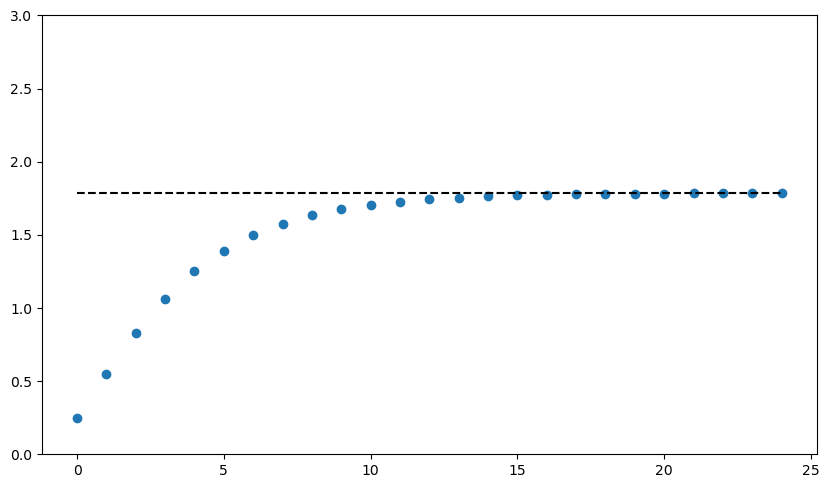

In [9]:
params = create_solow_params()
k_0 = 0.25
k_series = compute_iterates(k_0, g, params)
k_star = exact_fixed_point(params)

fig, ax = plt.subplots()
ax.plot(k_series, 'o')
ax.plot([k_star] * len(k_series), 'k--')
ax.set_ylim(0, 3)
plt.show()

Let's see the output for a long time series.

In [10]:
k_series = compute_iterates(k_0, g, params, n=10_000)
k_star_approx = k_series[-1]
k_star_approx

1.7846741842265788

This is close to the true value.

(solved_k)=

In [11]:
k_star

1.7846741842265788

#### Newton's Method 

In general, when applying Newton's fixed point method to some function $g$, 
we start with a guess $x_0$ of the fixed
point and then update by solving for the fixed point of a tangent line at
$x_0$.

To begin with, we recall that the first-order approximation of $g$ at $x_0$
(i.e., the first order Taylor approximation of $g$ at $x_0$) is
the function

```{math}
:label: motivation

\hat g(x) \approx g(x_0)+g'(x_0)(x-x_0)
```

We solve for the fixed point of $\hat g$ by calculating the $x_1$ that solves

$$
x_1=\frac{g(x_0)-g'(x_0) x_0}{1-g'(x_0)}
$$

Generalising the process above, Newton's fixed point method iterates on 

```{math}
:label: newtons_method

x_{t+1} = \frac{g(x_t) - g'(x_t) x_t}{ 1 - g'(x_t) },
\quad x_0 \text{ given}
```


To implement Newton's method we observe that the derivative of the law of motion for capital [](motion_law) is

```{math}
:label: newton_method2

g'(k) = \alpha s A k^{\alpha-1} + (1-\delta)

```

Let's define this:

In [12]:
def Dg(k, params):
    A, s, α, δ = params
    return α * A * s * k**(α-1) + (1 - δ)

Here's a function $q$ representing [](newtons_method).

In [13]:
def q(k, params):
    return (g(k, params) - Dg(k, params) * k) / (1 - Dg(k, params))

Now let's plot some trajectories.

In [14]:
def plot_trajectories(params, 
                      k0_a=0.8,  # first initial condition
                      k0_b=3.1,  # second initial condition
                      n=20,      # length of time series
                      fs=14):    # fontsize

    fig, axes = plt.subplots(2, 1, figsize=(10, 6))
    ax1, ax2 = axes

    ks1 = compute_iterates(k0_a, g, params, n)
    ax1.plot(ks1, "-o", label="successive approximation")

    ks2 = compute_iterates(k0_b, g, params, n)
    ax2.plot(ks2, "-o", label="successive approximation")

    ks3 = compute_iterates(k0_a, q, params, n)
    ax1.plot(ks3, "-o", label="newton steps")

    ks4 = compute_iterates(k0_b, q, params, n)
    ax2.plot(ks4, "-o", label="newton steps")

    for ax in axes:
        ax.plot(k_star * np.ones(n), "k--")
        ax.legend(fontsize=fs, frameon=False)
        ax.set_ylim(0.6, 3.2)
        ax.set_yticks((k_star,))
        ax.set_yticklabels(("$k^*$",), fontsize=fs)
        ax.set_xticks(np.linspace(0, 19, 20))
        
    plt.show()

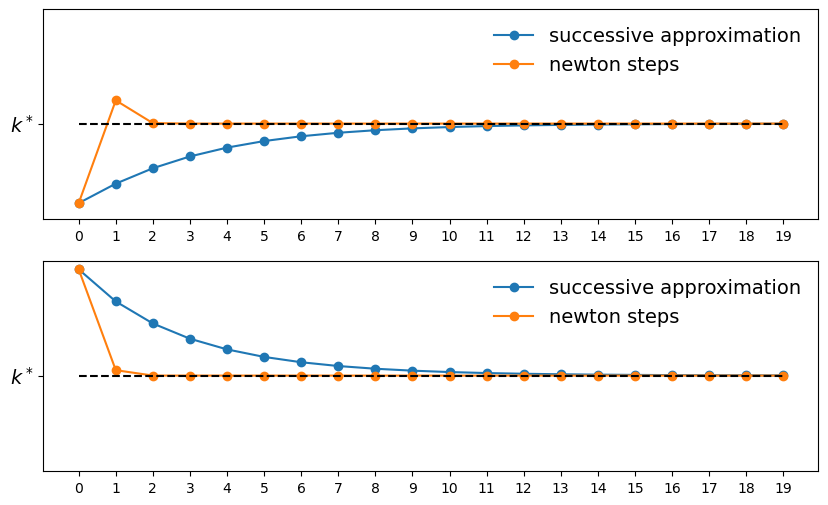

In [15]:
params = create_solow_params()
plot_trajectories(params)

We can see that Newton's method converges faster than successive approximation.


## Root-Finding in One Dimension

In the previous section we computed fixed points.

In fact Newton's method is more commonly associated with the problem of
finding zeros of functions.

Let's discuss this "root-finding" problem and then show how it is connected to
the problem of finding fixed points.



### Newton's Method for Zeros

Let's suppose we want to find an $x$ such that $f(x)=0$ for some smooth
function $f$ mapping real numbers to real numbers.

Suppose we have a guess $x_0$ and we want to update it to a new point $x_1$.

As a first step, we take the first-order approximation of $f$ around $x_0$:

$$
\hat f(x) \approx f\left(x_0\right)+f^{\prime}\left(x_0\right)\left(x-x_0\right)
$$

Now we solve for the zero of $\hat f$.  

In particular, we set $\hat{f}(x_1) = 0$ and solve for $x_1$ to get

$$
x_1 = x_0 - \frac{ f(x_0) }{ f'(x_0) },
\quad x_0 \text{ given}
$$

Generalizing the formula above, for one-dimensional zero-finding problems, Newton's method iterates on

```{math}
:label: oneD-newton
x_{t+1} = x_t - \frac{ f(x_t) }{ f'(x_t) },
\quad x_0 \text{ given}
```

The following code implements the iteration [](oneD-newton)

(first_newton_attempt)=

In [16]:
def newton(f, Df, x_0, tol=1e-7, max_iter=100_000):
    x = x_0

    # Implement the zero-finding formula
    def q(x):
        return x - f(x) / Df(x)

    error = tol + 1
    n = 0
    while error > tol:
        n += 1
        if(n > max_iter):
            raise Exception('Max iteration reached without convergence')
        y = q(x)
        error = np.abs(x - y)
        x = y
        print(f'iteration {n}, error = {error:.5f}')
    return x

Numerous libraries implement Newton's method in one dimension, including
SciPy, so the code is just for illustrative purposes.

(That said, when we want to apply Newton's method using techniques such as
automatic differentiation or GPU acceleration, it will be helpful to know how
to implement Newton's method ourselves.)


### Application to Finding Fixed Points

Now consider again the Solow fixed-point calculation, where we solve for $k$
satisfying $g(k) = k$.

We can convert to this to a zero-finding problem by setting $f(x) := g(x)-x$.

Any zero of $f$ is clearly a fixed point of $g$.

Let's apply this idea to the Solow problem

In [17]:
params = create_solow_params()
k_star_approx_newton = newton(f=lambda x: g(x, params) - x,
                              Df=lambda x: Dg(x, params) - 1,
                              x_0=0.8)

iteration 1, error = 1.27209
iteration 2, error = 0.28180
iteration 3, error = 0.00561
iteration 4, error = 0.00000
iteration 5, error = 0.00000


In [18]:
k_star_approx_newton

1.7846741842265788

The result confirms the descent we saw in the graphs above: a very accurate result is reached with only 5 iterations.



## Multivariate Newton’s Method

In this section, we introduce a two-good problem, present a
visualization of the problem, and solve for the equilibrium of the two-good market
using both a zero finder in `SciPy` and Newton's method.

We then expand the idea to a larger market with 5,000 goods and compare the
performance of the two methods again.

We will see a significant performance gain when using Netwon's method.


### A Two Goods Market Equilibrium

Let's start by computing the market equilibrium of a two-good problem.

We consider a market for two related products, good 0 and good 1, with
price vector $p = (p_0, p_1)$

Supply of good $i$ at price $p$,

$$ 
q^s_i (p) = b_i \sqrt{p_i} 
$$

Demand of good $i$ at price $p$ is,

$$ 
q^d_i (p) = \exp(-a_{i0} p_0) + \exp(-a_{i1} p_1) + c_i
$$

Here $c_i$, $b_i$ and $a_{ij}$ are parameters.

For example, the two goods might be computer components that are typically used together, in which case they are complements. Hence demand depends on the price of both components.

The excess demand function is,

$$
e_i(p) = q^d_i(p) - q^s_i(p), \quad i = 0, 1
$$


An equilibrium price vector $p^*$ satisfies $e_i(p^*) = 0$.


We set

$$
A = \begin{pmatrix}
            a_{00} & a_{01} \\
            a_{10} & a_{11}
        \end{pmatrix},
            \qquad 
    b = \begin{pmatrix}
            b_0 \\
            b_1
        \end{pmatrix}
    \qquad \text{and} \qquad
    c = \begin{pmatrix}
            c_0 \\
            c_1
        \end{pmatrix}
$$

for this particular question.

#### A Graphical Exploration

Since our problem is only two-dimensional, we can use graphical analysis to visualize and help understand the problem.

Our first step is to define the excess demand function

$$
e(p) = 
    \begin{pmatrix}
    e_0(p) \\
    e_1(p)
    \end{pmatrix}
$$

The function below calculates the excess demand for given parameters

In [19]:
def e(p, A, b, c):
    return np.exp(- A @ p) + c - b * np.sqrt(p)

Our default parameter values will be


$$
A = \begin{pmatrix}
            0.5 & 0.4 \\
            0.8 & 0.2
        \end{pmatrix},
            \qquad 
    b = \begin{pmatrix}
            0 \\
            0
        \end{pmatrix}
    \qquad \text{and} \qquad
    c = \begin{pmatrix}
            0 \\
            0
        \end{pmatrix}
$$

In [20]:
A = np.array([
    [0.5, 0.4],
    [0.8, 0.2]
])
b = np.ones(2)
c = np.ones(2)

At a price level of $p = (1, 0.5)$, the excess demand is

In [21]:
ex_demand = e((1.0, 0.5), A, b, c)

print(f'The excess demand for good 0 is {ex_demand[0]:.3f} \n'
      f'The excess demand for good 1 is {ex_demand[1]:.3f}')

The excess demand for good 0 is 0.497 
The excess demand for good 1 is 0.699


Next we plot the two functions $e_0$ and $e_1$ on a grid of $(p_0, p_1)$ values, using contour surfaces and lines.

We will use the following function to build the contour plots

In [22]:
def plot_excess_demand(ax, good=0, grid_size=100, grid_max=4, surface=True):

    # Create a 100x100 grid
    p_grid = np.linspace(0, grid_max, grid_size)
    z = np.empty((100, 100))

    for i, p_1 in enumerate(p_grid):
        for j, p_2 in enumerate(p_grid):
            z[i, j] = e((p_1, p_2), A, b, c)[good]

    if surface:
        cs1 = ax.contourf(p_grid, p_grid, z.T, alpha=0.5)
        plt.colorbar(cs1, ax=ax, format="%.6f")

    ctr1 = ax.contour(p_grid, p_grid, z.T, levels=[0.0])
    ax.set_xlabel("$p_0$")
    ax.set_ylabel("$p_1$")
    ax.set_title(f'Excess Demand for Good {good}')
    plt.clabel(ctr1, inline=1, fontsize=13)

Here's our plot of $e_0$:

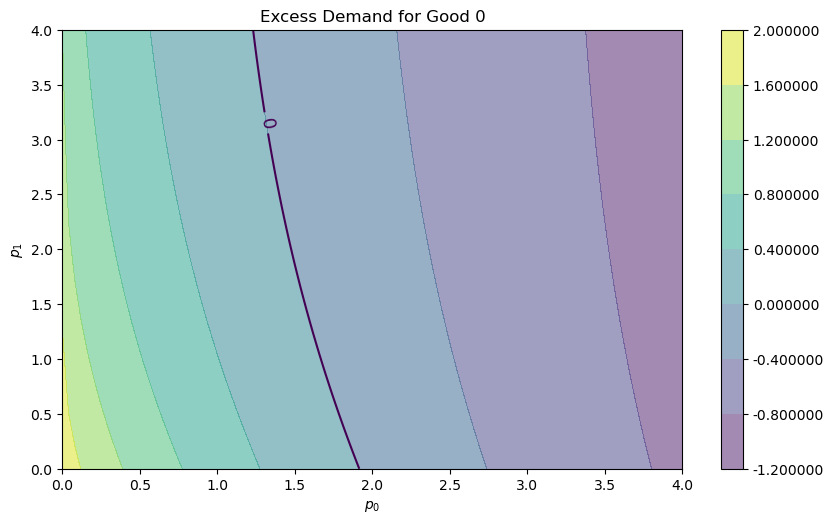

In [23]:
fig, ax = plt.subplots()
plot_excess_demand(ax, good=0)
plt.show()

Here's our plot of $e_1$:

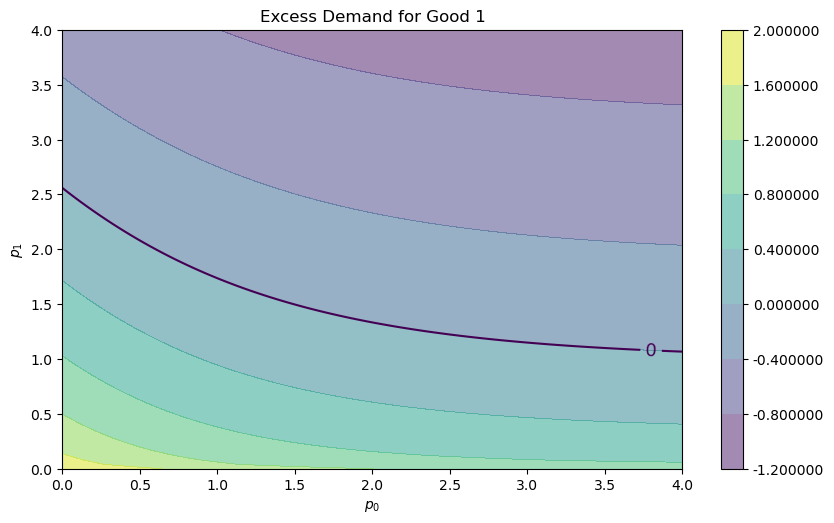

In [24]:
fig, ax = plt.subplots()
plot_excess_demand(ax, good=1)
plt.show()

We see the black contour line of zero, which tells us when $e_i(p)=0$.

For a price vector $p$ such that $e_i(p)=0$ we know that good $i$ is in equilibrium (demand equals supply).

If these two contour lines cross at some price vector $p^*$, then $p^*$ is an equilibrium price vector.

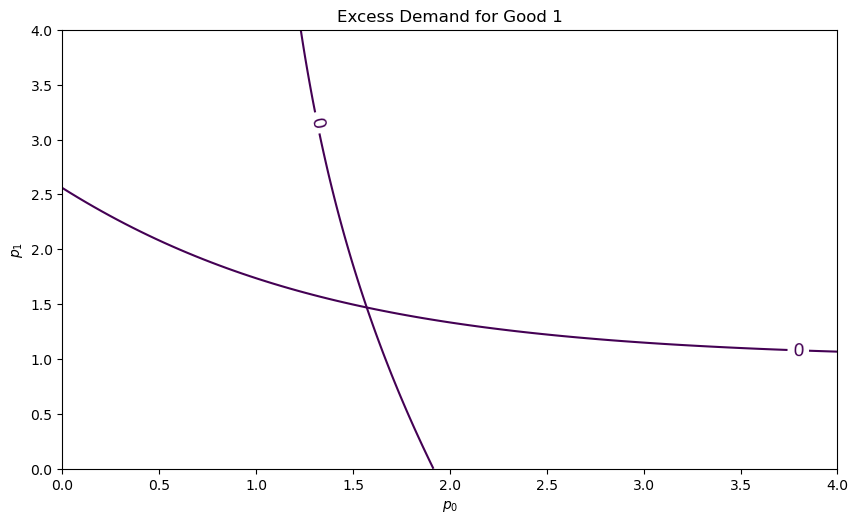

In [25]:
fig, ax = plt.subplots(figsize=(10, 5.7))
for good in (0, 1):
    plot_excess_demand(ax, good=good, surface=False)
plt.show()

It seems there is an equilibrium close to $p = (1.6, 1.5)$.


#### Using a Multidimensional Root Finder

To solve for $p^*$ more precisely, we use a zero-finding algorithm from `scipy.optimize`.

We supply $p = (1, 1)$ as our initial guess.

In [26]:
init_p = np.ones(2)

This uses the [modified Powell method](https://docs.scipy.org/doc/scipy/reference/optimize.root-hybr.html#optimize-root-hybr) to find the zero

In [27]:
%%time
solution = root(lambda p: e(p, A, b, c), init_p, method='hybr')

CPU times: user 262 µs, sys: 0 ns, total: 262 µs
Wall time: 248 µs


Here's the resulting value:

In [28]:
p = solution.x
p

array([1.57080182, 1.46928838])

This looks close to our guess from observing the figure. We can plug it back into $e$ to test that $e(p) \approx 0$:

In [29]:
np.max(np.abs(e(p, A, b, c)))

2.0383694732117874e-13

This is indeed a very small error.


#### Adding Gradient Information

In many cases, for zero-finding algorithms applied to smooth functions, supplying the [Jacobian](https://en.wikipedia.org/wiki/Jacobian_matrix_and_determinant) of the function leads to better convergence properties.

Here we manually calculate the elements of the Jacobian

$$
J(p) = 
    \begin{pmatrix}
        \frac{\partial e_0}{\partial p_0}(p) & \frac{\partial e_0}{\partial p_1}(p) \\
        \frac{\partial e_1}{\partial p_0}(p) & \frac{\partial e_1}{\partial p_1}(p)
    \end{pmatrix}
$$

In [30]:
def jacobian(p, A, b, c):
    p_0, p_1 = p
    a_00, a_01 = A[0, :]
    a_10, a_11 = A[1, :]
    j_00 = -a_00 * np.exp(-a_00 * p_0) - (b[0]/2) * p_0**(-1/2)
    j_01 = -a_01 * np.exp(-a_01 * p_1)
    j_10 = -a_10 * np.exp(-a_10 * p_0)
    j_11 = -a_11 * np.exp(-a_11 * p_1) - (b[1]/2) * p_1**(-1/2)
    J = [[j_00, j_01],
         [j_10, j_11]]
    return np.array(J)

In [31]:
%%time
solution = root(lambda p: e(p, A, b, c),
                init_p, 
                jac=lambda p: jacobian(p, A, b, c), 
                method='hybr')

CPU times: user 208 µs, sys: 69 µs, total: 277 µs
Wall time: 261 µs


Now the solution is even more accurate (although, in this low-dimensional problem, the difference is quite small):

In [32]:
p = solution.x
np.max(np.abs(e(p, A, b, c)))

1.3322676295501878e-15

#### Using Newton's Method

Now let's use Newton's method to compute the equilibrium price using the multivariate version of Newton's method

```{math}
:label: multi-newton

p_{n+1} = p_n - J_e(p_n)^{-1} e(p_n)
```

This is a multivariate version of [](oneD-newton)

(Here $J_e(p_n)$ is the Jacobian of $e$ evaluated at $p_n$.)

The iteration starts from some initial guess of the price vector $p_0$. 

Here, instead of coding Jacobian by hand, We use the `jax.jacobian()` function to auto-differentiate and calculate the Jacobian.

With only slight modification, we can generalize [our previous attempt](first_newton_attempt) to multi-dimensional problems

In [33]:
def newton(f, x_0, tol=1e-5, max_iter=10):
    x = x_0
    q = jax.jit(lambda x: x - jnp.linalg.solve(jax.jacobian(f)(x), f(x)))
    error = tol + 1
    n = 0
    while error > tol:
        n+=1
        if(n > max_iter):
            raise Exception('Max iteration reached without convergence')
        y = q(x)
        if(any(jnp.isnan(y))):
            raise Exception('Solution not found with NaN generated')
        error = jnp.linalg.norm(x - y)
        x = y
        print(f'iteration {n}, error = {error:.5f}')
    print('\n' + f'Result = {x} \n')
    return x

In [34]:
def e(p, A, b, c):
    return jnp.exp(- jnp.dot(A, p)) + c - b * jnp.sqrt(p)

We find the algorithm terminates in 4 steps

In [35]:
%%time
p = newton(lambda p: e(p, A, b, c), init_p).block_until_ready()

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


iteration 1, error = 0.62515
iteration 2, error = 0.11152
iteration 3, error = 0.00258
iteration 4, error = 0.00000

Result = [1.570802  1.4692882] 

CPU times: user 347 ms, sys: 8.41 ms, total: 356 ms
Wall time: 343 ms


In [36]:
np.max(np.abs(e(p, A, b, c)))

0.0

The result is very accurate. 

With the larger overhead, the speed is not better than the optimized `scipy` function.

However, things will change when we move to higher dimensional problems.



### A High-Dimensional Problem

Our next step is to investigate a large market with 5,000 goods.

To handle this large problem we will use Google JAX.

The excess demand function is essentially the same, but now the matrix $A$ is $5000 \times 5000$ and the parameter vectors $b$ and $c$ are $5000 \times 1$.

In [37]:
dim = 5_000
np.random.seed(123)

# Create a random matrix A and normalize the rows to sum to one
A = np.random.rand(dim, dim)
A = jnp.asarray(A)
s = jnp.sum(A, axis=0)
A = A / s

# Set up b and c
b = jnp.ones(dim)
c = jnp.ones(dim)

Here is essentially the same demand function we applied before, but now using `jax.numpy` for the calculations.

In [38]:
def e(p, A, b, c):
    return jnp.exp(- jnp.dot(A, p)) + c - b * jnp.sqrt(p)

Here's our initial condition

In [39]:
init_p = jnp.ones(dim)

By leveraging the power of Newton's method, JAX accelerated linear algebra,
automatic differentiation, and a GPU, we obtain a relatively small error for
this very large problem in just a few seconds:

In [40]:
%%time
p = newton(lambda p: e(p, A, b, c), init_p).block_until_ready()

iteration 1, error = 29.97755


iteration 2, error = 5.09284


iteration 3, error = 0.10971


iteration 4, error = 0.00005


iteration 5, error = 0.00001


iteration 6, error = 0.00000

Result = [1.5015959 1.4990965 1.4964362 ... 1.4844416 1.4900057 1.4991018] 

CPU times: user 1min, sys: 1.91 s, total: 1min 1s
Wall time: 11.6 s


In [41]:
np.max(np.abs(e(p, A, b, c)))

1.1920929e-07

With the same tolerance, SciPy's `root` function takes much longer to run,
even with the Jacobian supplied.

In [42]:
%%time
solution = root(lambda p: e(p, A, b, c),
                init_p, 
                jac=lambda p: jax.jacobian(e)(p, A, b, c), 
                method='hybr',
                tol=1e-5)

CPU times: user 2min 39s, sys: 1.68 s, total: 2min 41s
Wall time: 2min 26s


In [43]:
p = solution.x
np.max(np.abs(e(p, A, b, c)))

8.34465e-07

The result is also less accurate.



## Exercises

```{exercise-start}
:label: newton_ex1
```

Consider a three-dimensional extension of the Solow fixed point problem with

$$
A = \begin{pmatrix}
            2 & 3 & 3 \\
            2 & 4 & 2 \\
            1 & 5 & 1 \\
        \end{pmatrix},
            \quad
s = 0.2, \quad α = 0.5, \quad δ = 0.8
$$

As before the law of motion is

```{math}
    k_{t+1} = g(k_t) \quad \text{where} \quad
    g(k) := sAk^\alpha + (1-\delta) k
```

However $k_t$ is now a $3 \times 1$ vector.

Solve for the fixed point using Newton's method with the following initial values:

$$
\begin{aligned}
    k1_{0} &= (1, 1, 1) \\
    k2_{0} &= (3, 5, 5) \\
    k3_{0} &= (50, 50, 50)
\end{aligned}
$$

````{hint} 
:class: dropdown

- The computation of the fixed point is equivalent to computing $k^*$ such that $f(k^*) - k^* = 0$.

- If you are unsure about your solution, you can start with the solved example:

```{math}
A = \begin{pmatrix}
            2 & 0 & 0 \\
            0 & 2 & 0 \\
            0 & 0 & 2 \\
        \end{pmatrix}
```

with $s = 0.3$, $α = 0.3$, and $δ = 0.4$ and starting value: 


```{math}
k_0 = (1, 1, 1)
```

The result should converge to the [analytical solution](solved_k).
````

```{exercise-end}
```


```{solution-start} newton_ex1
:class: dropdown
```

Let's first define the parameters for this problem

In [44]:
A = jnp.array([[2.0, 3.0, 3.0],
               [2.0, 4.0, 2.0],
               [1.0, 5.0, 1.0]])

s = 0.2
α = 0.5
δ = 0.8

initLs = [jnp.ones(3),
          jnp.array([3.0, 5.0, 5.0]),
          jnp.repeat(50.0, 3)]

Then define the multivariate version of the formula for the [law of motion of captial](motion_law)

In [45]:
def multivariate_solow(k, A=A, s=s, α=α, δ=δ):
    return (s * jnp.dot(A, k**α) + (1 - δ) * k)

Let's run through each starting value and see the output

In [46]:
attempt = 1
for init in initLs:
    print(f'Attempt {attempt}: Starting value is {init} \n')

    %time k = newton(lambda k: multivariate_solow(k) - k, \
                     init).block_until_ready()
    print('-'*64)
    attempt +=1

Attempt 1: Starting value is [1. 1. 1.] 



iteration 1, error = 50.49632
iteration 2, error = 41.10939
iteration 3, error = 4.29413
iteration 4, error = 0.38543
iteration 5, error = 0.00544
iteration 6, error = 0.00000

Result = [3.8405812 3.8707178 3.4109194] 

CPU times: user 248 ms, sys: 8.3 ms, total: 257 ms
Wall time: 249 ms
----------------------------------------------------------------
Attempt 2: Starting value is [3. 5. 5.] 



iteration 1, error = 2.07011
iteration 2, error = 0.12642
iteration 3, error = 0.00060
iteration 4, error = 0.00000

Result = [3.8405812 3.8707178 3.4109194] 

CPU times: user 143 ms, sys: 0 ns, total: 143 ms
Wall time: 139 ms
----------------------------------------------------------------
Attempt 3: Starting value is [50. 50. 50.] 



iteration 1, error = 73.00943


iteration 2, error = 6.49379
iteration 3, error = 0.68070
iteration 4, error = 0.01620
iteration 5, error = 0.00001
iteration 6, error = 0.00000

Result = [3.8405812 3.8707182 3.4109194] 

CPU times: user 327 ms, sys: 4.17 ms, total: 331 ms
Wall time: 323 ms
----------------------------------------------------------------


We find that the results are invariant to the starting values given the well-defined property of this question.

But the number of iterations it takes to converge is dependent on the starting values.

Let substitute the output back to the formulate to check our last result

In [47]:
multivariate_solow(k) - k

Array([0.0000000e+00, 0.0000000e+00, 2.3841858e-07], dtype=float32)

Note the error is very small.

We can also test our results on the known solution

In [48]:
A = jnp.array([[2.0, 0.0, 0.0],
               [0.0, 2.0, 0.0],
               [0.0, 0.0, 2.0]])

s = 0.3
α = 0.3
δ = 0.4

init = jnp.repeat(1.0, 3)


%time k = newton(lambda k: multivariate_solow(k, A=A, s=s, α=α, δ=δ) - k, \
                 init).block_until_ready()

iteration 1, error = 1.57459
iteration 2, error = 0.21345
iteration 3, error = 0.00205
iteration 4, error = 0.00000

Result = [1.7846744 1.7846744 1.7846744] 

CPU times: user 276 ms, sys: 7.9 ms, total: 284 ms
Wall time: 279 ms


The result is very close to the ground truth but still slightly different.

We can increase the precision of the floating point numbers and restrict the tolerance to obtain a more accurate approximation (see detailed discussion in the [lecture on JAX](https://python-programming.quantecon.org/jax_intro.html#differences))

In [49]:
from jax.config import config

config.update("jax_enable_x64", True)

init = init.astype('float64')

%time k = newton(lambda k: multivariate_solow(k, A=A, s=s, α=α, δ=δ) - k, \
                 init,\
                 tol=1e-7).block_until_ready()

iteration 1, error = 1.57459
iteration 2, error = 0.21345
iteration 3, error = 0.00205
iteration 4, error = 0.00000
iteration 5, error = 0.00000

Result = [1.78467418 1.78467418 1.78467418] 

CPU times: user 265 ms, sys: 8.12 ms, total: 273 ms
Wall time: 268 ms


We can see it steps towards a more accurate solution.

```{solution-end}
```


```{exercise-start}
:label: newton_ex2
```

In this exercise, let's try different initial values and check how Newton's method responds to different starting points.

Let's define a three-good problem with the following default values:

$$
A = \begin{pmatrix}
            0.2 & 0.1 & 0.7 \\
            0.3 & 0.2 & 0.5 \\
            0.1 & 0.8 & 0.1 \\
        \end{pmatrix},
            \qquad 
b = \begin{pmatrix}
            1 \\
            1 \\
            1
        \end{pmatrix}
    \qquad \text{and} \qquad
c = \begin{pmatrix}
            1 \\
            1 \\
            1
        \end{pmatrix}
$$

For this exercise, use the following extreme price vectors as initial values:

$$

\begin{aligned}
    p1_{0} &= (5, 5, 5) \\
    p2_{0} &= (1, 1, 1) \\
    p3_{0} &= (4.5, 0.1, 4)
\end{aligned}
$$

Set the tolerance to $0.0$ for more accurate output.


```{hint} 
:class: dropdown

Similar to [exercise 1](newton_ex1), enabling `float64` for JAX can improve the precision of our results.
```


```{exercise-end}
```

```{solution-start} newton_ex2
:class: dropdown
```

Define parameters and initial values

In [50]:
A = jnp.array([
    [0.2, 0.1, 0.7],
    [0.3, 0.2, 0.5],
    [0.1, 0.8, 0.1]
])

b = jnp.array([1.0, 1.0, 1.0])
c = jnp.array([1.0, 1.0, 1.0])

initLs = [jnp.repeat(5.0, 3),
          jnp.ones(3),
          jnp.array([4.5, 0.1, 4.0])] 

Let’s run through each initial guess and check the output

In [51]:
attempt = 1
for init in initLs:
    print(f'Attempt {attempt}: Starting value is {init} \n')

    init = init.astype('float64')

    %time p = newton(lambda p: e(p, A, b, c), \
                 init, \
                 tol=0.0).block_until_ready()
    print('-'*64)
    attempt +=1

Attempt 1: Starting value is [5. 5. 5.] 



iteration 1, error = 9.24381


Exception: Solution not found with NaN generated

----------------------------------------------------------------
Attempt 2: Starting value is [1. 1. 1.] 



iteration 1, error = 0.73419
iteration 2, error = 0.12472
iteration 3, error = 0.00269
iteration 4, error = 0.00000
iteration 5, error = 0.00000
iteration 6, error = 0.00000
iteration 7, error = 0.00000

Result = [1.49744442 1.49744442 1.49744442] 

CPU times: user 145 ms, sys: 4.22 ms, total: 149 ms
Wall time: 143 ms
----------------------------------------------------------------
Attempt 3: Starting value is [4.5 0.1 4. ] 



iteration 1, error = 4.89202
iteration 2, error = 1.21206
iteration 3, error = 0.69421
iteration 4, error = 0.16895
iteration 5, error = 0.00521
iteration 6, error = 0.00000
iteration 7, error = 0.00000
iteration 8, error = 0.00000

Result = [1.49744442 1.49744442 1.49744442] 

CPU times: user 144 ms, sys: 0 ns, total: 144 ms
Wall time: 140 ms
----------------------------------------------------------------


We can find that Newton's method may fail for some starting values.

Sometimes it may take a few initial guesses to achieve convergence.

Substitute the result back to the formula to check our result

In [52]:
e(p, A, b, c)

Array([0., 0., 0.], dtype=float64)

We can see the result is very accurate.

```{solution-end}
```